In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_50688/1666183220.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

In [2]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (-73.95673 40.69289),-73.956733,40.692888
1,Amnesty,5,POINT (-73.97285 40.62937),-73.972852,40.629372
2,Amnesty,1,POINT (-73.96565 40.70615),-73.965655,40.706149
3,Amnesty,7,POINT (-73.90359 40.67201),-73.903590,40.672012
4,Amnesty,1,POINT (-73.95976 40.67575),-73.959759,40.675751


In [3]:
building_gdf = gpd.read_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')
building_gdf.head()

,index,geometry
0,20.0,"POLYGON ((-73.98473 40.70375, -73.98595 40.703..."
1,30.0,"POLYGON ((-73.98694 40.70317, -73.98717 40.703..."
2,34.0,"POLYGON ((-73.98033 40.70311, -73.98075 40.703..."
3,35.0,"POLYGON ((-73.99323 40.70255, -73.99325 40.702..."
4,42.0,"POLYGON ((-73.98292 40.70237, -73.98433 40.702..."


In [4]:
building_gdf = building_gdf.rename(columns = {'index':'Block'})
building_gdf.columns

Index(['Block', 'geometry'], dtype='object')

In [5]:
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((-74.00198 40.56960, -74.00209 ..."


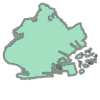

In [6]:
bk_bndry.geometry.values[0]

In [7]:
#convert data to equidistant projection system UTM Zone 18 aka NYC, EPSG:32618

camera_locs = camera_locs.to_crs(32618)
building_gdf = building_gdf.to_crs(32618)
bk_bndry = bk_bndry.to_crs(32618)

In [8]:
camera_locs.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
building_gdf.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
bk_bndry.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
#redefine x and y columns
camera_locs['x'] = camera_locs.geometry.x
camera_locs['y'] = camera_locs.geometry.y
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (588147.072 4505188.861),588147.071612,4.505189e+06
1,Amnesty,5,POINT (586867.513 4498122.217),586867.512967,4.498122e+06
2,Amnesty,1,POINT (587375.934 4506652.088),587375.933703,4.506652e+06
3,Amnesty,7,POINT (592666.168 4502926.211),592666.167996,4.502926e+06
4,Amnesty,1,POINT (587913.940 4503283.593),587913.939630,4.503284e+06


In [12]:
#standardize the camera count metric to use as our target variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data = np.asarray(camera_locs['Camera_Count']).reshape(-1, 1)
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(data)
y_data = scaler.transform(data)

X_data = np.vstack([camera_locs['x'],camera_locs['y']]).T
# y = np.array(camera_locs["Data_Source"] == "Amnesty", dtype=int)

In [13]:
y_data[:10]

array([[0.25  ],
       [0.25  ],
       [0.    ],
       [0.375 ],
       [0.    ],
       [0.125 ],
       [0.0625],
       [0.    ],
       [0.1875],
       [0.    ]])

In [14]:
X_data[:10]

array([[ 588147.07161245, 4505188.86062826],
       [ 586867.51296664, 4498122.21674541],
       [ 587375.93370312, 4506652.08754618],
       [ 592666.16799647, 4502926.21110367],
       [ 587913.93963028, 4503283.59252384],
       [ 587841.31876905, 4495391.16488008],
       [ 588340.31358102, 4507900.0470682 ],
       [ 589735.68823608, 4492479.78569519],
       [ 591343.2992308 , 4502219.92109406],
       [ 586154.4109412 , 4499844.40780503]])

In [15]:
kde = KernelDensity(bandwidth = 200, metric="haversine", kernel="gaussian", algorithm="ball_tree")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.8, random_state=123)
kde.fit(X_train)

KernelDensity(algorithm='ball_tree', bandwidth=200, metric='haversine')

In [17]:
# Define the minimum and maximum bounds of the raster
min_x, min_y, max_x, max_y = camera_locs.total_bounds

Nx = len(camera_locs['x'].unique())
Ny = len(camera_locs['y'].unique())

# x coordinates of the grid cells
grid_sizex = (max_x-min_x)/Nx
grid_sizey = (max_y-min_y)/Ny

xgrid = np.arange(min_x, max_x, grid_sizex)
# y coordinates of the grid cells
ygrid = np.arange(min_y, max_y, grid_sizey)

X, Y = np.meshgrid(xgrid, ygrid[::-1])

In [18]:
print(min_x, min_y, max_x, max_y)

581157.7243299014 4491754.499870358 596500.9171182256 4510276.4174596425


In [19]:
print(Nx,Ny)

7694 7694


In [20]:
print(grid_sizex,grid_sizey)

1.9941763436865352 2.407319676278201


In [21]:
print(len(xgrid),len(ygrid))

7694 7694


In [22]:
X.shape

(7694, 7694)

In [23]:
Y.shape

(7694, 7694)

ValueError: Axis limits cannot be NaN or Inf

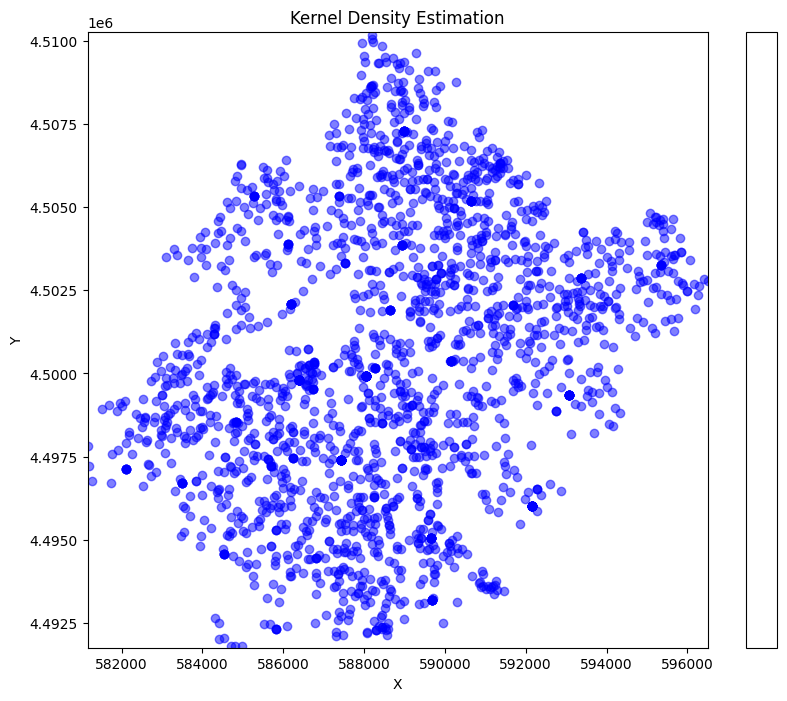

In [24]:
import matplotlib.pyplot as plt

# Generate grid points for evaluation
# x_grid, y_grid = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100),
#                              np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100))
# grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy = np.vstack([Y.ravel(), X.ravel()]).T

# Compute log-density values for grid points
log_density = kde.score_samples(xy)
Z = np.exp(log_density).reshape(X.shape)
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot training data as points
ax.scatter(X_train[:, 0], X_train[:, 1], c='b', label='Training Data', alpha=0.5)

# Plot KDE output as contour plot

levels = np.linspace(0, Z.max(), 25)
# plt.contourf(X,Y,Z, levels=levels,cmap=plt.cm.Reds)
contour = ax.contourf(X, Y, Z, levels = levels, cmap = plt.cm.Reds, alpha=0.5)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Kernel Density Estimation')

# Add a colorbar
cbar = fig.colorbar(contour)

# Display the plot
plt.show()

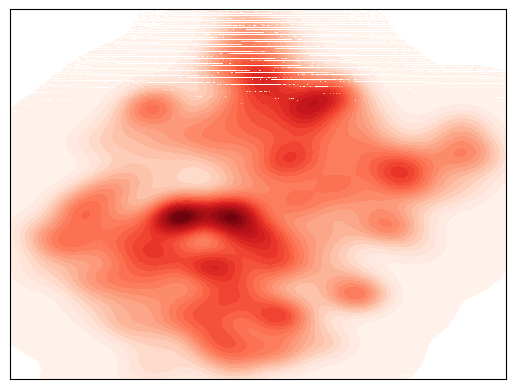

In [45]:
# plot contours of the density
levels = np.linspace(0, Z.max(), 25)
plt.contourf(X,Y,Z, levels=levels,cmap=plt.cm.Reds)
# plt.contour(Y,X, land_reference, levels=[-9998], colors="k", linestyles="solid")
plt.xticks([])
plt.yticks([])

# plt.title(species_names[i])

plt.show()